# Micrograd

For understanding backgropogation

Micrograd takes values and performs back propogation

In [5]:
import math

from graphviz import Digraph

In [4]:
# visualize computation graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [11]:
# data structure for keeping value and performing backprop
class Value:
    def __init__(self, data, _children: tuple = (), _op=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0
        self._op = _op

    def __repr__(self) -> str:
        return f"Value({self.data}) | grad={self.grad}"
    
    def __neg__(self):
        return self * -1
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad   # z = x+y -> dz/dx = 1 * dx/do
            other.grad += 1.0 * out.grad  # z = x+y -> dz/dy = 1 * dy/do
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # z = xy -> dz/dx = y * dx/do 
            other.grad += self.data * out.grad  # z = xy -> dz/dy = x * dy/do 

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return self**-1 * other

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad # Power Rule

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), f"exp")

        def _backward():
            self.grad += out.data * out.grad # derivative of e^x is itself

        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), f"tanh")

        def _backward():
            self.grad += (1-math.tanh(self.data)**2) * out.grad

        out._backward = _backward
        return out

    def relu(self):
        out = Value(max(self.data, 0), (self,), "ReLU")

        def _backward():
            self.grad += (self.data > 0) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo_order = []
        visited = set()
        def topo_sort(node):
            if node in visited:
                return
            visited.add(node)
            for child in node._prev:
                topo_sort(child)
            
            topo_order.append(node)
        
        topo_sort(self)
        topo_order = reversed(topo_order)

        self.grad = 1
        for node in topo_order:
            node._backward()

Value(0.9995685936824674) | grad=0


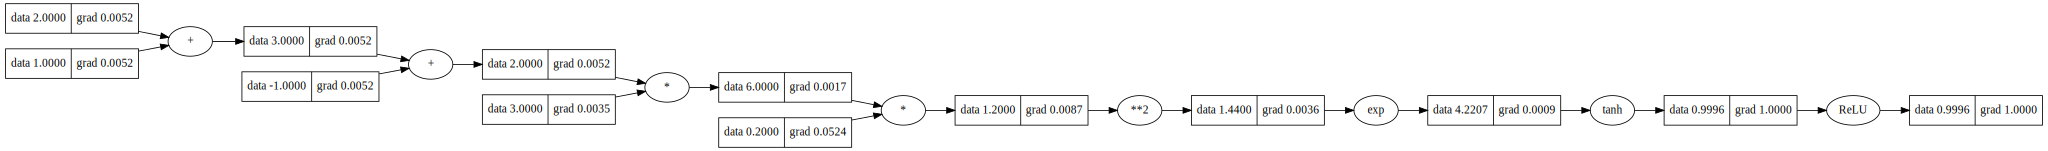

In [12]:
# test Value Implementation
x = Value(1.0)
y = ((3 * (2 + x - 1) / 5)**2).exp().tanh().relu()
print(y)
y.backward()

draw_dot(y)

In [ ]:
# Neuron in Neural Network
class Neuron:
    def __init__(self):
        pass

In [ ]:
# Layer in Neural Network
class Layer:
    def __init__(self):
        pass

In [ ]:
# Multi-Layer Perceptron
class MLP:
    def __init__(self):
        pass